In [79]:

import os
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from scipy.stats import ttest_ind

random_seed = 1234
DATA_DIR = '/Users/malithidesilva/fyp/model_1/calibration'
RESULT_DIR = '/Users/malithidesilva/fyp/model_1/calibration/result_calib'


### Brief Score & Log Loss FOR NON CALLIBRATED

### Non Callibrated Best Model VS Non Caliibrated FRS 

In [80]:


# Function to calculate metrics
def calculate_metrics(pipeline, X_test, y_test):
    y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    
    brier_score = brier_score_loss(y_test, y_test_pred_proba)
    log_loss_value = log_loss(y_test, y_test_pred_proba)
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    return {
        'Brier Score': brier_score,
        'Log Loss': log_loss_value,
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Function to calculate p-values using bootstrapping
def calculate_p_values(probabilities1, probabilities2, y_test1, y_test2, n_bootstrap=1000):
    brier_scores_1 = []
    brier_scores_2 = []
    log_losses_1 = []
    log_losses_2 = []
    roc_aucs_1 = []
    roc_aucs_2 = []
    
    for _ in range(n_bootstrap):
        # Bootstrap samples
        y_test_sample_1, prob_sample_1 = resample(y_test1, probabilities1)
        y_test_sample_2, prob_sample_2 = resample(y_test2, probabilities2)
        
        # Brier Score
        brier_scores_1.append(brier_score_loss(y_test_sample_1, prob_sample_1))
        brier_scores_2.append(brier_score_loss(y_test_sample_2, prob_sample_2))
        
        # Log Loss
        log_losses_1.append(log_loss(y_test_sample_1, prob_sample_1))
        log_losses_2.append(log_loss(y_test_sample_2, prob_sample_2))
        
        # ROC AUC
        roc_aucs_1.append(roc_auc_score(y_test_sample_1, prob_sample_1))
        roc_aucs_2.append(roc_auc_score(y_test_sample_2, prob_sample_2))
    
    # Calculate p-values
    brier_score_p_value = ttest_ind(brier_scores_1, brier_scores_2).pvalue
    log_loss_p_value = ttest_ind(log_losses_1, log_losses_2).pvalue
    roc_auc_p_value = ttest_ind(roc_aucs_1, roc_aucs_2).pvalue
    
    return brier_score_p_value, log_loss_p_value, roc_auc_p_value

# Function to determine significance based on p-value
def significance_label(p_value, alpha=0.05):
    return 'Significant' if p_value < alpha else 'Not Significant'

# Load SHAP-reduced test data
shap_reduced_data = joblib.load(os.path.join(DATA_DIR, 'shap_reduced_data.pkl'))
X_test_shap = shap_reduced_data['X_test_shap']
y_test_selected = shap_reduced_data['y_test_shap']

# Load the SHAP model pipeline
model_result_dir = os.path.join(DATA_DIR)
pipeline = joblib.load(os.path.join(model_result_dir, 'RF_full_model.pkl'))

# Calculate metrics for the SHAP-reduced model
shap_metrics = calculate_metrics(pipeline, X_test_shap, y_test_selected)

# Load FRS data
frs_data = joblib.load(os.path.join(DATA_DIR, 'frs_data.pkl'))
X_test_frs_prob = frs_data['X_test_frs']['FRS_score_coeff3']  # FRS predicted probabilities

# Ensure binary outcome is 0/1
y_test_ = y_test_selected.copy()
y_test_[y_test_ > 0] = 1

# Calculate metrics for the non-calibrated FRS model
frs_metrics = {
    'Brier Score': brier_score_loss(y_test_, X_test_frs_prob),
    'Log Loss': log_loss(y_test_, X_test_frs_prob),
    'ROC AUC': roc_auc_score(y_test_, X_test_frs_prob),
    'Accuracy': accuracy_score(y_test_, (X_test_frs_prob > 0.5).astype(int)),
    'Precision': precision_score(y_test_, (X_test_frs_prob > 0.5).astype(int)),
    'Recall': recall_score(y_test_, (X_test_frs_prob > 0.5).astype(int)),
    'F1 Score': f1_score(y_test_, (X_test_frs_prob > 0.5).astype(int))
}

# --- Step 4: Calculate p-values and significance ---
# Calculate p-values and significance
brier_p_value, log_loss_p_value, roc_auc_p_value = calculate_p_values(
    pipeline.predict_proba(X_test_shap)[:, 1],
    X_test_frs_prob,
    y_test_selected,
    y_test_
)
brier_significance = significance_label(brier_p_value)
log_loss_significance = significance_label(log_loss_p_value)
roc_auc_significance = significance_label(roc_auc_p_value)

# Combine the results into a DataFrame
combined_results = pd.DataFrame({
    'Metric': list(shap_metrics.keys()),
    'Non-calibrated RF Model': list(shap_metrics.values()),
    'Non-calibrated FRS Model': list(frs_metrics.values()),
    'p-value': [brier_p_value, log_loss_p_value, roc_auc_p_value] + [''] * (len(shap_metrics) - 3),
    'Significance': [brier_significance, log_loss_significance, roc_auc_significance] + [''] * (len(shap_metrics) - 3)
})

# Save to a CSV file
combined_csv_file_path = os.path.join(RESULT_DIR, 'non_calibrated_combined_metrics_with_p_values.csv')
combined_results.to_csv(combined_csv_file_path, index=False)
print(f"Non-calibrated combined metrics with p-values saved to {combined_csv_file_path}")


Non-calibrated combined metrics with p-values saved to /Users/malithidesilva/fyp/model_1/calibration/result_calib/non_calibrated_combined_metrics_with_p_values.csv


### NRI for Non Callibrated Best Model and Non Callibrated FRS

In [81]:



# Function to calculate detailed NRI metrics
def calculate_detailed_nri(prob_old, prob_new, y_true, threshold=0.5):
    """
    Calculate detailed NRI metrics including upward and downward reclassification.

    Parameters:
    prob_old (array-like): Probabilities from the old model (e.g., FRS).
    prob_new (array-like): Probabilities from the new model (e.g., SHAP-based model).
    y_true (array-like): True binary outcomes (0 or 1).
    threshold (float): Decision threshold for classification. Default is 0.5.

    Returns:
    result (dict): Dictionary with detailed NRI metrics.
    """
    # Classify using the old and new model probabilities
    class_old = (prob_old > threshold).astype(int)
    class_new = (prob_new > threshold).astype(int)

    # Calculate upward and downward reclassification for events
    events_upward = np.sum((class_new == 1) & (class_old == 0) & (y_true == 1))
    events_downward = np.sum((class_new == 0) & (class_old == 1) & (y_true == 1))
    total_events = np.sum(y_true == 1)

    # Calculate upward and downward reclassification for non-events
    non_events_upward = np.sum((class_new == 1) & (class_old == 0) & (y_true == 0))
    non_events_downward = np.sum((class_new == 0) & (class_old == 1) & (y_true == 0))
    total_non_events = np.sum(y_true == 0)

    # Calculate NRI components
    nri_events = (events_upward - events_downward) / total_events if total_events > 0 else 0
    nri_non_events = (non_events_downward - non_events_upward) / total_non_events if total_non_events > 0 else 0
    nri_total = nri_events + nri_non_events

    # Compile the results into a dictionary
    result = {
        'threshold': threshold,
        'events_upward': events_upward,
        'events_downward': events_downward,
        'non_events_upward': non_events_upward,
        'non_events_downward': non_events_downward,
        'total_events': total_events,
        'total_non_events': total_non_events,
        'NRI': nri_total
    }

    return result

# Example usage

# Load SHAP-reduced test data and pipeline
shap_reduced_data = joblib.load(os.path.join(DATA_DIR, 'shap_reduced_data.pkl'))
X_test_shap = shap_reduced_data['X_test_shap']
y_test_selected = shap_reduced_data['y_test_shap']

model_result_dir = os.path.join(DATA_DIR)  # Assuming you want to use the RF model
pipeline = joblib.load(os.path.join(model_result_dir, 'RF_full_model.pkl'))

# Calculate SHAP model predicted probabilities
shap_pred_prob = pipeline.predict_proba(X_test_shap)[:, 1]  # SHAP model predicted probabilities

# Load FRS data
frs_data = joblib.load(os.path.join(DATA_DIR, 'frs_data.pkl'))
X_test_frs_prob = frs_data['X_test_frs']['FRS_score_coeff3']  # FRS predicted probabilities

# Ensure binary outcome is 0/1
y_test_ = y_test_selected.copy()
y_test_[y_test_ > 0] = 1

# Define the thresholds
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Calculate NRI for each threshold
nri_results = []
for threshold in thresholds:
    nri_result = calculate_detailed_nri(X_test_frs_prob, shap_pred_prob, y_test_, threshold=threshold)
    nri_results.append(nri_result)

# Convert results to a DataFrame and save as CSV
nri_df = pd.DataFrame(nri_results)
nri_csv_file_path = os.path.join(RESULT_DIR, 'nri_detailed_results_multiple_thresholds.csv')
nri_df.to_csv(nri_csv_file_path, index=False)
print(f"NRI detailed metrics saved to {nri_csv_file_path}")

NRI detailed metrics saved to /Users/malithidesilva/fyp/model_1/calibration/result_calib/nri_detailed_results_multiple_thresholds.csv


In [82]:
print(RESULT_DIR)

/Users/malithidesilva/fyp/model_1/calibration/result_calib


### Plot Callibraion Curves - just to asess before callibration

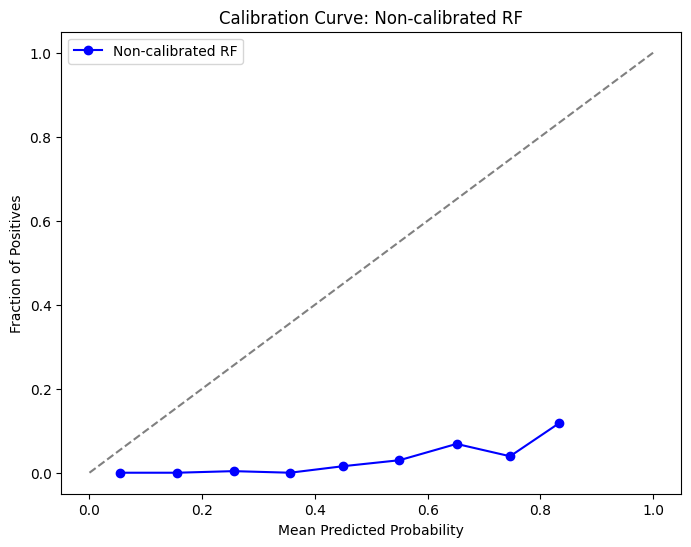

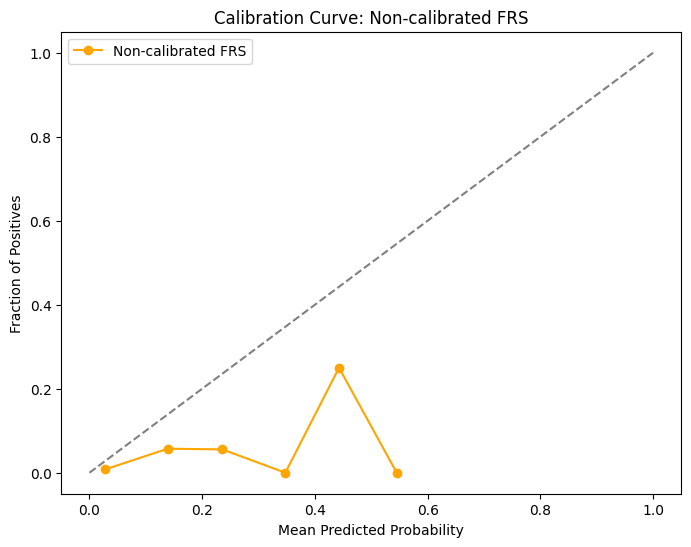

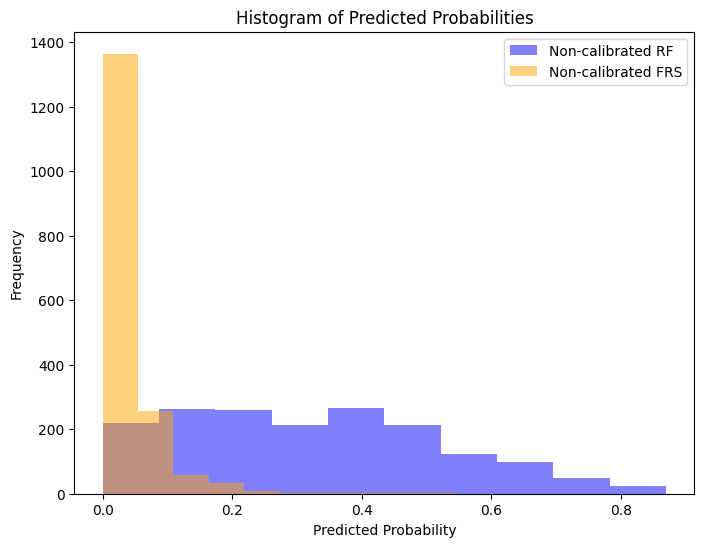

In [83]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calibration curve for SHAP model (Non-calibrated)
prob_true_shap, prob_pred_shap = calibration_curve(y_test_selected, shap_pred_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred_shap, prob_true_shap, marker='o', label='Non-calibrated RF', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve: Non-calibrated RF')
plt.legend()
plt.show()

# Calibration curve for FRS model (Non-calibrated)
prob_true_frs, prob_pred_frs = calibration_curve(y_test_, X_test_frs_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred_frs, prob_true_frs, marker='o', label='Non-calibrated FRS', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve: Non-calibrated FRS')
plt.legend()
plt.show()

# Combined Histogram of predicted probabilities for both models
plt.figure(figsize=(8, 6))
plt.hist(shap_pred_prob, bins=10, alpha=0.5, label='Non-calibrated RF', color='blue')
plt.hist(X_test_frs_prob, bins=10, alpha=0.5, label='Non-calibrated FRS', color='orange')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.legend()
plt.show()


### Brief Score & Log Loss FOR CALLIBRATED

### Callibrated BEST Model VS Callibrated FRS

In [84]:
# Load the original imputed data for FRS
splitted_data = joblib.load(os.path.join(DATA_DIR, 'train_test_data.pkl'))

X_train = splitted_data['X_train']
y_train = splitted_data['y_train']

X_calib = splitted_data['X_calib']
y_calib = splitted_data['y_calib']

X_test = splitted_data['X_test']
y_test = splitted_data['y_test']

# Ensure y_train, y_calib, and y_test are binary (0/1)
y_train = (y_train > 0).astype(int)
y_calib = (y_calib > 0).astype(int)
y_test = (y_test > 0).astype(int)


In [85]:
# Load SHAP-reduced data
shap_reduced_data = joblib.load(os.path.join(DATA_DIR, 'shap_reduced_data.pkl'))

X_train_shap = shap_reduced_data['X_train_shap']
y_train_shap = shap_reduced_data['y_train_shap']
X_calib_shap = shap_reduced_data['X_calib_shap']
y_calib_selected = shap_reduced_data['y_calib_shap']
X_test_shap = shap_reduced_data['X_test_shap']
y_test_selected = shap_reduced_data['y_test_shap']

# Ensure y_train_shap, y_calib_selected, and y_test_selected are binary (0/1)
y_train_shap = (y_train_shap > 0).astype(int)
y_calib_selected = (y_calib_selected > 0).astype(int)
y_test_selected = (y_test_selected > 0).astype(int)

# Confirm the shapes are consistent with the respective datasets
assert X_train_shap.shape[0] == len(y_train_shap), "Mismatch in X_train_shap and y_train_shap"
assert X_calib_shap.shape[0] == len(y_calib_selected), "Mismatch in X_calib_shap and y_calib_selected"
assert X_test_shap.shape[0] == len(y_test_selected), "Mismatch in X_test_shap and y_test_selected"


# %%
from sklearn.isotonic import IsotonicRegression
import joblib
import os

# Load FRS probabilities for training, calibration, and test sets
frs_data = joblib.load(os.path.join(DATA_DIR, 'frs_data.pkl'))

X_train_frs_prob = frs_data['X_train_frs']['FRS_score_coeff3']  # FRS probabilities for training
X_calib_frs_prob = frs_data['X_calib_frs']['FRS_score_coeff3']  # FRS probabilities for calibration
X_test_frs_prob = frs_data['X_test_frs']['FRS_score_coeff3']    # FRS probabilities for test

# Confirm the shapes are consistent with the respective datasets
assert X_train.shape[0] == len(X_train_frs_prob), "Mismatch in X_train and X_train_frs_prob"
assert X_calib.shape[0] == len(X_calib_frs_prob), "Mismatch in X_calib and X_calib_frs_prob"
assert X_test.shape[0] == len(X_test_frs_prob), "Mismatch in X_test and X_test_frs_prob"

# --- Step 1: Calibrate FRS Model using Isotonic Regression ---
# Calibrate the FRS probabilities using Isotonic Regression
frs_isotonic = IsotonicRegression(out_of_bounds='clip')
frs_isotonic.fit(X_train_frs_prob, y_train)  # Fit on training data

# Apply the calibration to the test set
frs_calib_prob = frs_isotonic.transform(X_test_frs_prob)
from sklearn.calibration import CalibratedClassifierCV

# --- Step 2: Calibrate SHAP Model using Isotonic Regression ---
# Load the SHAP model pipeline
model_result_dir = os.path.join(DATA_DIR)
pipeline = joblib.load(os.path.join(model_result_dir, 'RF_full_model.pkl'))

# Calibrate the SHAP model using Isotonic Regression
shap_isotonic = CalibratedClassifierCV(pipeline, method='isotonic', cv='prefit')
shap_isotonic.fit(X_calib_shap, y_calib_selected)  # Fit on calibration data

# Apply the calibration to the test set
shap_calib_prob = shap_isotonic.predict_proba(X_test_shap)[:, 1]

from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import os

# Function to calculate metrics
def calculate_metrics(probabilities, y_test):
    y_test_pred = (probabilities > 0.5).astype(int)
    
    brier_score = brier_score_loss(y_test, probabilities)
    log_loss_value = log_loss(y_test, probabilities)
    roc_auc = roc_auc_score(y_test, probabilities)
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    return {
        'Brier Score': brier_score,
        'Log Loss': log_loss_value,
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }



In [86]:
from sklearn.utils import resample
from scipy.stats import ttest_ind

# Function to calculate p-values using bootstrapping
def calculate_p_values(probabilities1, probabilities2, y_test1, y_test2, n_bootstrap=1000):
    brier_scores_1 = []
    brier_scores_2 = []
    log_losses_1 = []
    log_losses_2 = []
    roc_aucs_1 = []
    roc_aucs_2 = []
    
    for _ in range(n_bootstrap):
        # Bootstrap samples
        y_test_sample_1, prob_sample_1 = resample(y_test1, probabilities1)
        y_test_sample_2, prob_sample_2 = resample(y_test2, probabilities2)
        
        # Brier Score
        brier_scores_1.append(brier_score_loss(y_test_sample_1, prob_sample_1))
        brier_scores_2.append(brier_score_loss(y_test_sample_2, prob_sample_2))
        
        # Log Loss
        log_losses_1.append(log_loss(y_test_sample_1, prob_sample_1))
        log_losses_2.append(log_loss(y_test_sample_2, prob_sample_2))
        
        # ROC AUC
        roc_aucs_1.append(roc_auc_score(y_test_sample_1, prob_sample_1))
        roc_aucs_2.append(roc_auc_score(y_test_sample_2, prob_sample_2))
    
    # Calculate p-values
    brier_score_p_value = ttest_ind(brier_scores_1, brier_scores_2).pvalue
    log_loss_p_value = ttest_ind(log_losses_1, log_losses_2).pvalue
    roc_auc_p_value = ttest_ind(roc_aucs_1, roc_aucs_2).pvalue
    
    return brier_score_p_value, log_loss_p_value, roc_auc_p_value

# Function to determine significance based on p-value
def significance_label(p_value, alpha=0.05):
    return 'Significant' if p_value < alpha else 'Not Significant'

# --- Step 3: Calculate Metrics ---
# Calculate metrics for the calibrated RF model
shap_calib_metrics = calculate_metrics(shap_calib_prob, y_test_selected)

# Calculate metrics for the calibrated FRS model
frs_calib_metrics = calculate_metrics(frs_calib_prob, y_test)

# --- Step 4: Calculate p-values and significance ---
# Calculate p-values and significance
brier_p_value, log_loss_p_value, roc_auc_p_value = calculate_p_values(shap_calib_prob, frs_calib_prob, y_test_selected, y_test)
brier_significance = significance_label(brier_p_value)
log_loss_significance = significance_label(log_loss_p_value)
roc_auc_significance = significance_label(roc_auc_p_value)

# Create DataFrame with all metrics and significance
combined_calib_results = pd.DataFrame({
    'Metric': list(shap_calib_metrics.keys()),
    'Calibrated RF Model': list(shap_calib_metrics.values()),
    'Calibrated FRS Model': list(frs_calib_metrics.values()),
    'p-value': [brier_p_value, log_loss_p_value, roc_auc_p_value] + [''] * (len(shap_calib_metrics) - 3),
    'Significance': [brier_significance, log_loss_significance, roc_auc_significance] + [''] * (len(shap_calib_metrics) - 3)
})

# Save to a CSV file
combined_calib_csv_file_path = os.path.join(RESULT_DIR, 'combined_calibrated_metrics_with_p_values_as_columns.csv')
combined_calib_results.to_csv(combined_calib_csv_file_path, index=False)
print(f"Combined calibrated metrics with p-values saved to {combined_calib_csv_file_path}")


/Users/malithidesilva/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/malithidesilva/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Combined calibrated metrics with p-values saved to /Users/malithidesilva/fyp/model_1/calibration/result_calib/combined_calibrated_metrics_with_p_values_as_columns.csv


In [87]:
import numpy as np

# Function to calculate detailed NRI metrics
def calculate_detailed_nri(prob_old, prob_new, y_true, threshold=0.5):
    class_old = (prob_old > threshold).astype(int)
    class_new = (prob_new > threshold).astype(int)

    events_upward = np.sum((class_new == 1) & (class_old == 0) & (y_true == 1))
    events_downward = np.sum((class_new == 0) & (class_old == 1) & (y_true == 1))
    total_events = np.sum(y_true == 1)

    non_events_upward = np.sum((class_new == 1) & (class_old == 0) & (y_true == 0))
    non_events_downward = np.sum((class_new == 0) & (class_old == 1) & (y_true == 0))
    total_non_events = np.sum(y_true == 0)

    nri_events = (events_upward - events_downward) / total_events if total_events > 0 else 0
    nri_non_events = (non_events_downward - non_events_upward) / total_non_events if total_non_events > 0 else 0
    nri_total = nri_events + nri_non_events

    return {
        'threshold': threshold,
        'events_upward': events_upward,
        'events_downward': events_downward,
        'non_events_upward': non_events_upward,
        'non_events_downward': non_events_downward,
        'total_events': total_events,
        'total_non_events': total_non_events,
        'NRI': nri_total
    }

# --- Step 4: NRI Analysis ---
# Define the thresholds
thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.5]

# Calculate NRI for the calibrated models across different thresholds
calibrated_nri_results = []
for threshold in thresholds:
    nri_result = calculate_detailed_nri(frs_calib_prob, shap_calib_prob, y_test_selected, threshold=threshold)
    calibrated_nri_results.append(nri_result)

# Convert results to a DataFrame and save as CSV
calibrated_nri_df = pd.DataFrame(calibrated_nri_results)
calibrated_nri_csv_file_path = os.path.join(RESULT_DIR, 'calibrated_nri_detailed_results_multiple_thresholds.csv')
calibrated_nri_df.to_csv(calibrated_nri_csv_file_path, index=False)
print(f"Calibrated NRI detailed metrics saved to {calibrated_nri_csv_file_path}")

Calibrated NRI detailed metrics saved to /Users/malithidesilva/fyp/model_1/calibration/result_calib/calibrated_nri_detailed_results_multiple_thresholds.csv


### Plot Callibraion Curves - just to asess before callibration

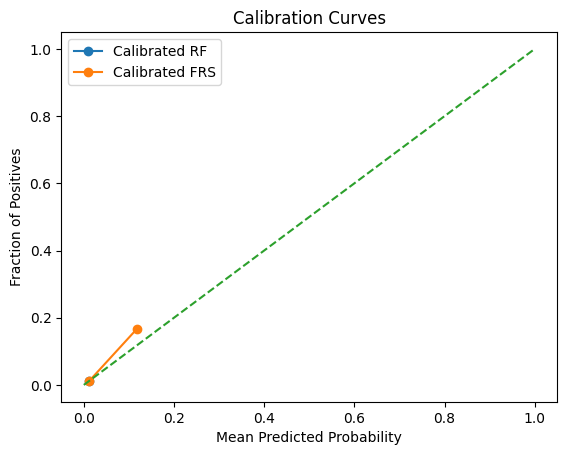

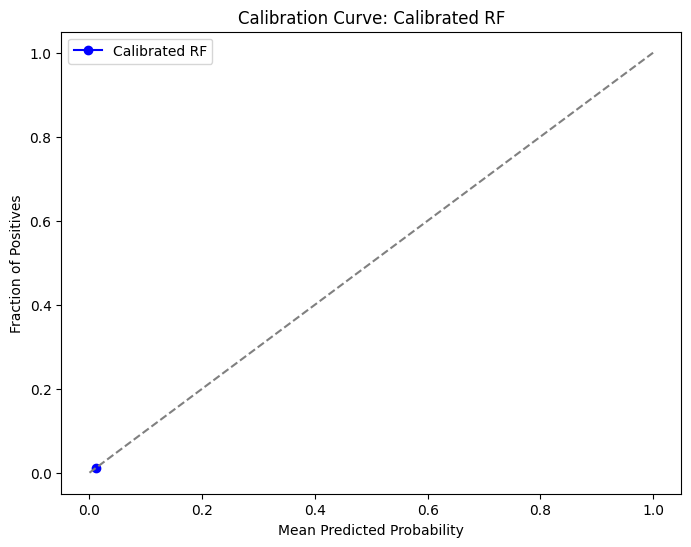

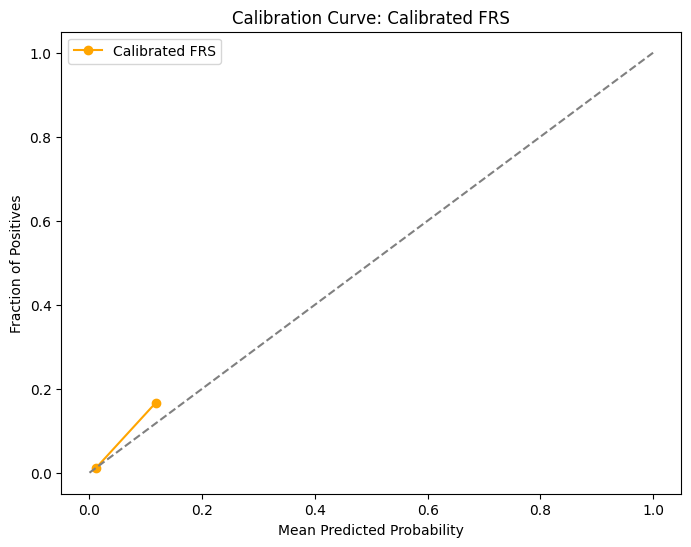

In [88]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calibration curve for SHAP model
prob_true, prob_pred = calibration_curve(y_test_selected, shap_calib_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated RF')

# Calibration curve for FRS model
prob_true_frs, prob_pred_frs = calibration_curve(y_test, frs_calib_prob, n_bins=10)
plt.plot(prob_pred_frs, prob_true_frs, marker='o', label='Calibrated FRS')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves')
plt.legend()
plt.show()

# Calibration curve for SHAP model
prob_true_shap, prob_pred_shap = calibration_curve(y_test_selected, shap_calib_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred_shap, prob_true_shap, marker='o', label='Calibrated RF', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve: Calibrated RF')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calibration curve for FRS model
prob_true_frs, prob_pred_frs = calibration_curve(y_test, frs_calib_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred_frs, prob_true_frs, marker='o', label='Calibrated FRS', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve: Calibrated FRS')
plt.legend()
plt.show()


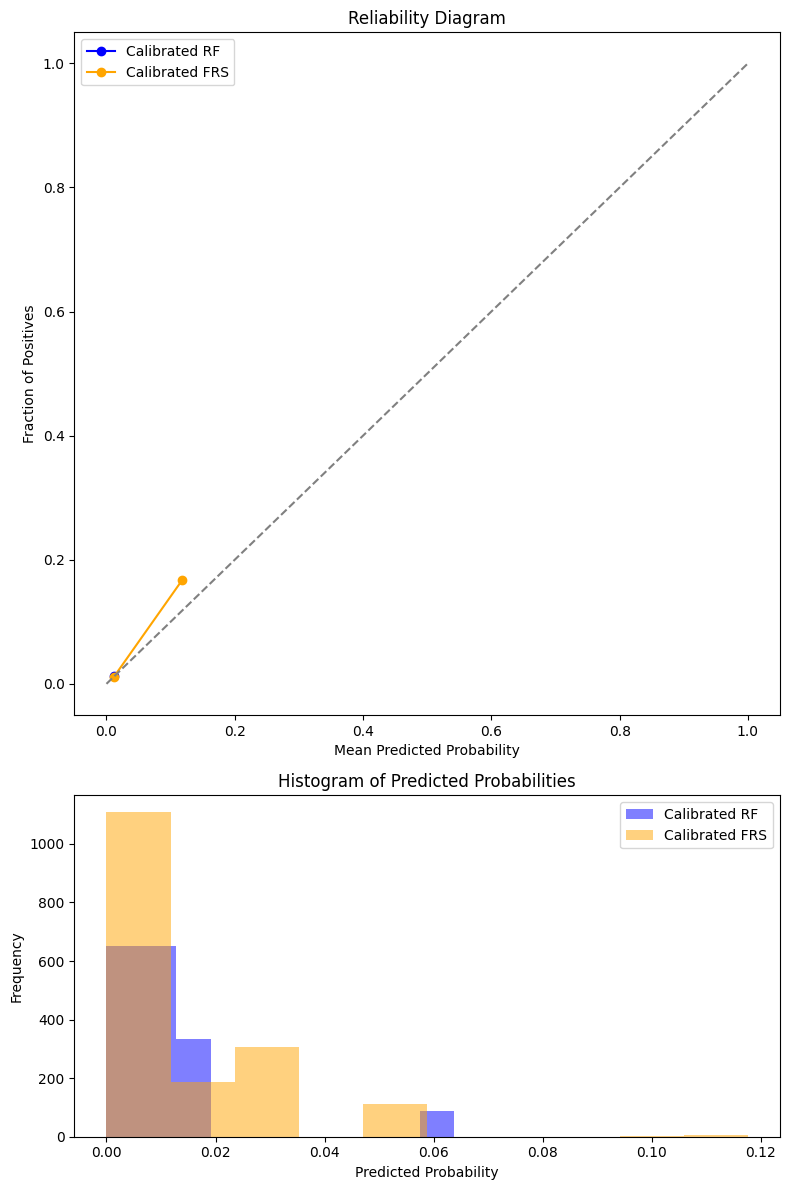

In [89]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Create a figure with subplots
fig, ax = plt.subplots(2, 1, figsize=(8, 12), gridspec_kw={'height_ratios': [2, 1]})

# Reliability diagram (calibration curve) for SHAP model
prob_true_shap, prob_pred_shap = calibration_curve(y_test_selected, shap_calib_prob, n_bins=10)
ax[0].plot(prob_pred_shap, prob_true_shap, marker='o', label='Calibrated RF', color='blue')

# Reliability diagram (calibration curve) for FRS model
prob_true_frs, prob_pred_frs = calibration_curve(y_test, frs_calib_prob, n_bins=10)
ax[0].plot(prob_pred_frs, prob_true_frs, marker='o', label='Calibrated FRS', color='orange')

# Plot the perfect calibration line
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray')

# Formatting the plot
ax[0].set_xlabel('Mean Predicted Probability')
ax[0].set_ylabel('Fraction of Positives')
ax[0].set_title('Reliability Diagram')
ax[0].legend()

# Histogram of predicted probabilities
ax[1].hist(shap_calib_prob, bins=10, alpha=0.5, label='Calibrated RF', color='blue')
ax[1].hist(frs_calib_prob, bins=10, alpha=0.5, label='Calibrated FRS', color='orange')
ax[1].set_xlabel('Predicted Probability')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Predicted Probabilities')
ax[1].legend()

plt.tight_layout()
plt.show()


In [90]:
import joblib
import os
import pandas as pd
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.utils import resample
from scipy.stats import ttest_ind

# Assuming the non-calibrated best model's probabilities are already calculated as `shap_pred_prob`
# Assuming the calibrated best model's probabilities are already calculated as `shap_calib_prob`

# Step 1: Calculate metrics for the non-calibrated best model (already done previously)
non_calib_metrics = calculate_metrics(shap_pred_prob, y_test_selected)

# Step 2: Calculate metrics for the calibrated best model (already done previously)
calib_metrics = calculate_metrics(shap_calib_prob, y_test_selected)

# Step 3: Calculate p-values and significance between non-calibrated and calibrated models
brier_p_value, log_loss_p_value, roc_auc_p_value = calculate_p_values(shap_pred_prob, shap_calib_prob, y_test_selected, y_test_selected)
brier_significance = significance_label(brier_p_value)
log_loss_significance = significance_label(log_loss_p_value)
roc_auc_significance = significance_label(roc_auc_p_value)

# Step 4: Combine the results into a DataFrame
comparison_results = pd.DataFrame({
    'Metric': ['Brier Score', 'Log Loss', 'ROC AUC'],
    'Non-calibrated Best Model': [non_calib_metrics['Brier Score'], non_calib_metrics['Log Loss'], non_calib_metrics['ROC AUC']],
    'Calibrated Best Model': [calib_metrics['Brier Score'], calib_metrics['Log Loss'], calib_metrics['ROC AUC']],
    'p-value': [brier_p_value, log_loss_p_value, roc_auc_p_value],
    'Significance': [brier_significance, log_loss_significance, roc_auc_significance]
})

# Step 5: Save the results to a CSV file
comparison_csv_file_path = os.path.join(RESULT_DIR, 'non_calibrated_vs_calibrated_best_model_metrics_with_p_values.csv')
comparison_results.to_csv(comparison_csv_file_path, index=False)
print(f"Non-calibrated vs Calibrated best model metrics with p-values saved to {comparison_csv_file_path}")


/Users/malithidesilva/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Non-calibrated vs Calibrated best model metrics with p-values saved to /Users/malithidesilva/fyp/model_1/calibration/result_calib/non_calibrated_vs_calibrated_best_model_metrics_with_p_values.csv


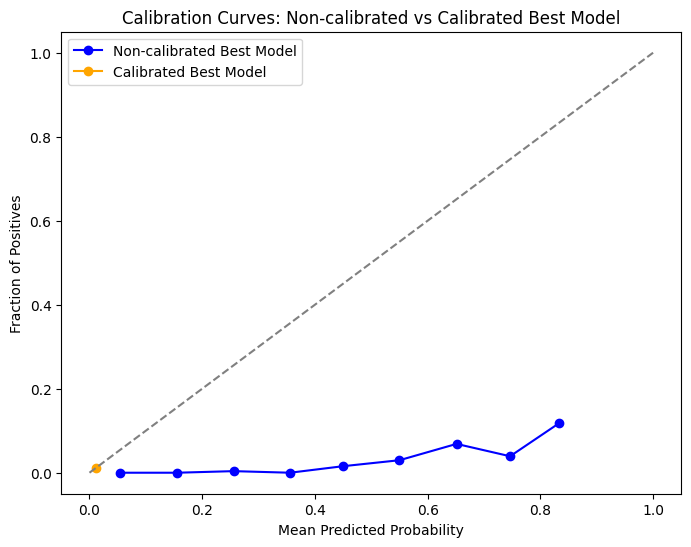

In [91]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calibration curve for the non-calibrated best model
prob_true_non_calib, prob_pred_non_calib = calibration_curve(y_test_selected, shap_pred_prob, n_bins=10)

# Calibration curve for the calibrated best model
prob_true_calib, prob_pred_calib = calibration_curve(y_test_selected, shap_calib_prob, n_bins=10)

# Plot the calibration curves
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_non_calib, prob_true_non_calib, marker='o', label='Non-calibrated Best Model', color='blue')
plt.plot(prob_pred_calib, prob_true_calib, marker='o', label='Calibrated Best Model', color='orange')

# Plot the perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Formatting the plot
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves: Non-calibrated vs Calibrated Best Model')
plt.legend()
plt.show()


In [92]:
import numpy as np
import pandas as pd
import os

# Function to calculate detailed NRI metrics
def calculate_detailed_nri(prob_old, prob_new, y_true, threshold=0.5):
    """
    Calculate detailed NRI metrics including upward and downward reclassification.

    Parameters:
    prob_old (array-like): Probabilities from the old model (e.g., non-calibrated model).
    prob_new (array-like): Probabilities from the new model (e.g., calibrated model).
    y_true (array-like): True binary outcomes (0 or 1).
    threshold (float): Decision threshold for classification. Default is 0.5.

    Returns:
    result (dict): Dictionary with detailed NRI metrics.
    """
    # Classify using the old and new model probabilities
    class_old = (prob_old > threshold).astype(int)
    class_new = (prob_new > threshold).astype(int)

    # Calculate upward and downward reclassification for events
    events_upward = np.sum((class_new == 1) & (class_old == 0) & (y_true == 1))
    events_downward = np.sum((class_new == 0) & (class_old == 1) & (y_true == 1))
    total_events = np.sum(y_true == 1)

    # Calculate upward and downward reclassification for non-events
    non_events_upward = np.sum((class_new == 1) & (class_old == 0) & (y_true == 0))
    non_events_downward = np.sum((class_new == 0) & (class_old == 1) & (y_true == 0))
    total_non_events = np.sum(y_true == 0)

    # Calculate NRI components
    nri_events = (events_upward - events_downward) / total_events if total_events > 0 else 0
    nri_non_events = (non_events_downward - non_events_upward) / total_non_events if total_non_events > 0 else 0
    nri_total = nri_events + nri_non_events

    # Compile the results into a dictionary
    result = {
        'threshold': threshold,
        'events_upward': events_upward,
        'events_downward': events_downward,
        'non_events_upward': non_events_upward,
        'non_events_downward': non_events_downward,
        'total_events': total_events,
        'total_non_events': total_non_events,
        'NRI': nri_total
    }

    return result

# Define the thresholds
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Calculate NRI for the non-calibrated vs calibrated models across different thresholds
nri_results = []
for threshold in thresholds:
    nri_result = calculate_detailed_nri(shap_pred_prob, shap_calib_prob, y_test_selected, threshold=threshold)
    nri_results.append(nri_result)

# Convert results to a DataFrame and save as CSV
nri_df = pd.DataFrame(nri_results)
nri_csv_file_path = os.path.join(RESULT_DIR, 'nri_non_calibrated_vs_calibrated_results.csv')
nri_df.to_csv(nri_csv_file_path, index=False)
print(f"NRI results for non-calibrated vs calibrated models saved to {nri_csv_file_path}")


NRI results for non-calibrated vs calibrated models saved to /Users/malithidesilva/fyp/model_1/calibration/result_calib/nri_non_calibrated_vs_calibrated_results.csv
